# Module 6 Assignment
Sarah Henry

## Datasets

Use the Storm Prediction Center tornado dataset https://www.spc.noaa.gov/wcm/data/1950-2021_actual_tornadoes.csv

Also, use the ENSO, PDO, NAO, and AO dataframe from earlier module.

## Your assignment

1) Aggregate the tornado data over the following states into a monthly count of tornadoes:
   
   - Illinois
   
2. Merge this monthly tornado dataset with the ENSO, PDO, NAO, and AO dataframe created in Module 4 Notebook 1.

3. Create a random forest regression model and use features that include the 4 climate indices to predict the monthly number of tornadoes.  Create a scatter plot of the predicted and observed number of tornadoes over these states.  Report the correlation coefficient and RMSE of your model.

4. Create a one-hot encoding for the month of the year.  Repeat the scatterplot and compare the RMSE and correlation coefficient values.

5. Perform a feature importance and multipass permutation analysis of your features.

6. Create a SHAP Summary Plot showing feature importance and feature effects.

7. Create a SHAP Feature Dependence for the ENSO index.

8. Any observations on the importance of the various features in your model from the XAI techniques you tried?


Import statements

In [28]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error
from scipy.stats import pearsonr
from sklearn.inspection import permutation_importance

import shap

1) Aggregate the tornado data over the following states into a monthly count of tornadoes:
   
   - Illinois

In [29]:
data = pd.read_csv("./data/1950-2021_actual_tornadoes.csv")

data_IL = data.loc[data["st"].astype(str) == "IL"].copy()
print(data_IL.head())

data_IL["Date"] = pd.to_datetime(
    data_IL["yr"].astype(str)
    + "-" + data_IL["mo"].astype(str)
)  # sets all days in the month equal to 1 for aggregation

monthly_IL = (
    data_IL.groupby("Date")
    .size()
    .rename("tor_count")
    .reset_index()
    .sort_values("Date")
)

print(monthly_IL.head())
monthly_IL['Date'] = pd.to_datetime(monthly_IL['Date'])

     om    yr  mo  dy        date      time  tz  st  stf  stn  ...   len  wid  \
6   198  1950  12   2  1950-12-02  15:00:00   3  IL   17    7  ...  18.8   50   
7   199  1950  12   2  1950-12-02  16:00:00   3  IL   17    8  ...  18.0  200   
9   201  1950  12   2  1950-12-02  17:30:00   3  IL   17    9  ...   9.6   50   
12    6  1950   1  25  1950-01-25  21:00:00   3  IL   17    3  ...   0.1  100   
15    2  1950   1   3  1950-01-03  11:55:00   3  IL   17    2  ...   3.6  130   

    ns  sn  sg   f1   f2  f3  f4  fc  
6    1   1   1  119  117   0   0   0  
7    1   1   1  119    5   0   0   0  
9    1   1   1  157    0   0   0   0  
12   1   1   1   91    0   0   0   0  
15   1   1   1  135    0   0   0   0  

[5 rows x 29 columns]
        Date  tor_count
0 1950-01-01          2
1 1950-03-01          1
2 1950-06-01          1
3 1950-07-01          1
4 1950-12-01          3


2. Merge this monthly tornado dataset with the ENSO, PDO, NAO, and AO dataframe created in Module 4 Notebook 1.

In [30]:
indicies = pd.read_csv("./data/M4N1_indicies.csv")
indicies['Date'] = pd.to_datetime(indicies['Date'])

data = monthly_IL.merge(indicies, on='Date', how='inner')
data

,Date,tor_count,ENSO,PDO,NAO,AO
0,1951-06-01,2,0.2,-1.77,-1.64,-0.918
1,1951-11-01,2,-0.8,-0.31,-0.39,-0.069
2,1951-12-01,1,-0.7,-1.45,1.32,1.987
3,1952-03-01,2,0.5,-1.67,-1.49,-1.859
4,1952-05-01,1,0.8,-2.07,-1.12,-0.774
...,...,...,...,...,...,...
435,2021-06-01,15,0.4,-1.82,0.77,0.845
436,2021-07-01,8,1.4,-2.00,0.03,0.630
437,2021-08-01,16,0.6,-0.95,-0.28,-0.209
438,2021-10-01,10,0.7,-3.13,-2.29,-0.146


3. Create a random forest regression model and use features that include the 4 climate indices to predict the monthly number of tornadoes.  Create a scatter plot of the predicted and observed number of tornadoes over these states.  Report the correlation coefficient and RMSE of your model.


In [31]:
feature_cols = ["ENSO", "PDO", "NAO", "AO"]
X = data[feature_cols].values
y = data["tor_count"].values

X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.25, random_state=0
)

In [32]:
rf = RandomForestRegressor(
    n_estimators=300,
    random_state=0
)

rf.fit(X_train, y_train)

y_pred = rf.predict(X_test)
rmse = np.sqrt(mean_squared_error(y_test, y_pred))
r, scrap = pearsonr(y_test, y_pred)

print(f"RMSE: {rmse:.2f}")
print(f"Correlation coefficient (r): {r:.2f}")


RMSE: 8.02
Correlation coefficient (r): -0.06


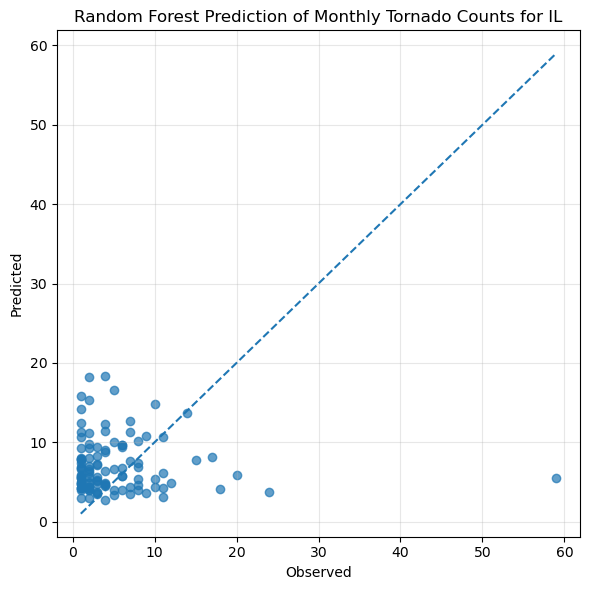

In [33]:
plt.figure(figsize=(6, 6))
plt.scatter(y_test, y_pred, alpha=0.7)
plt.plot([y_test.min(), y_test.max()],
         [y_test.min(), y_test.max()],
         linestyle="--")

plt.xlabel("Observed")
plt.ylabel("Predicted")
plt.title("Random Forest Prediction of Monthly Tornado Counts for IL")

plt.grid(True,alpha=0.3)
plt.tight_layout()
plt.show()


4. Create a one-hot encoding for the month of the year.  Repeat the scatterplot and compare the RMSE and correlation coefficient values.


In [34]:
data["month"] = data["Date"].dt.month
month_dummies = pd.get_dummies(data["month"], prefix="month")

X_month = pd.concat(
    [data[["ENSO", "PDO", "NAO", "AO"]], month_dummies],
    axis=1
)

y = data["tor_count"].values

X_train, X_test, y_train, y_test = train_test_split(
    X_month.values, y, test_size=0.25, random_state=0
)

rf_month = RandomForestRegressor(
    n_estimators=300,
    random_state=0
)

rf_month.fit(X_train, y_train)

y_pred = rf_month.predict(X_test)
rmse_month = np.sqrt(mean_squared_error(y_test, y_pred))
r_month, scrap = pearsonr(y_test, y_pred)

print(f"RMSE (one hot): {rmse_month:.2f}")
print(f"Correlation coefficient (one hot): {r_month:.2f}")

RMSE (one hot): 7.20
Correlation coefficient (one hot): 0.11


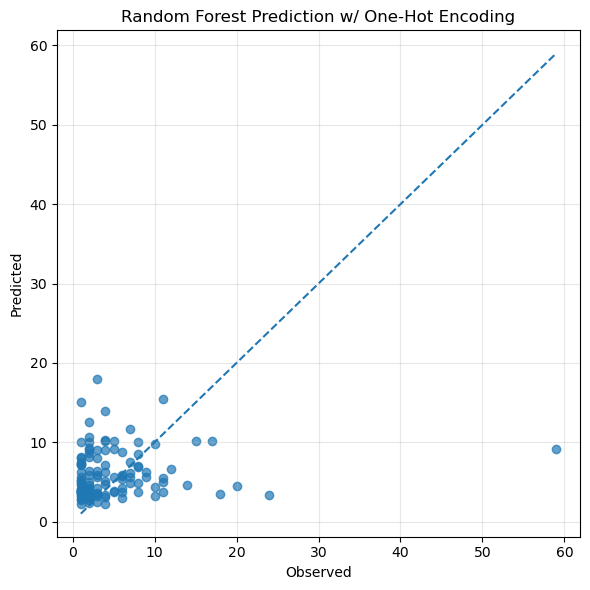

In [35]:
plt.figure(figsize=(6, 6))
plt.scatter(y_test, y_pred, alpha=0.7)
plt.plot([y_test.min(), y_test.max()],
         [y_test.min(), y_test.max()],
         linestyle="--")

plt.xlabel("Observed")
plt.ylabel("Predicted")
plt.title("Random Forest Prediction w/ One-Hot Encoding")

plt.grid(True,alpha=0.3)
plt.tight_layout()
plt.show()


With the one-hot encoding, the RMSE was similar (8.02 vs 7.20), but the correlation increased (-.06 to .11).

5. Perform a feature importance and multipass permutation analysis of your features.


In [36]:
rf_importance = pd.Series(
    rf_month.feature_importances_,
    index=X_month.columns
).sort_values(ascending=False)

print(rf_importance)

NAO         0.231062
PDO         0.229105
AO          0.217017
ENSO        0.167425
month_6     0.048326
month_5     0.045089
month_4     0.033046
month_12    0.009287
month_8     0.005785
month_3     0.005006
month_7     0.002724
month_2     0.002017
month_11    0.001555
month_9     0.001375
month_1     0.000605
month_10    0.000578
dtype: float64


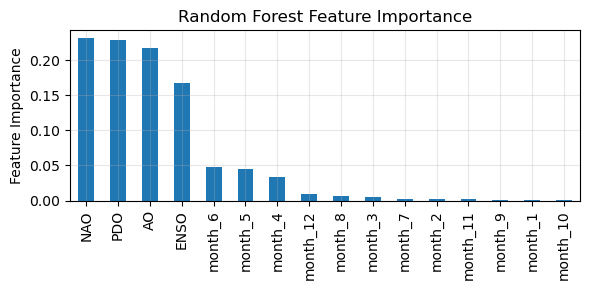

In [37]:
plt.figure(figsize=(6, 3))
rf_importance.plot(kind="bar")
plt.ylabel("Feature Importance")
plt.title("Random Forest Feature Importance")
plt.grid(True,alpha=0.3)
plt.tight_layout()
plt.show()

In [38]:
perm = permutation_importance(
    rf_month,
    X_test,
    y_test,
    n_repeats=30,
    random_state=0,
    scoring="neg_root_mean_squared_error"
)


In [39]:
perm_importance = pd.DataFrame(
    {
        "mean_importance": perm.importances_mean,
        "std_importance": perm.importances_std,
    },
    index=X_month.columns
).sort_values("mean_importance", ascending=False)

print(perm_importance)


          mean_importance  std_importance
month_4          0.545686        0.351923
NAO              0.463077        0.207732
month_6          0.287242        0.202589
ENSO             0.270911        0.399699
AO               0.153096        0.210870
PDO              0.085269        0.249196
month_5          0.081296        0.213688
month_2          0.022022        0.011458
month_11         0.012259        0.004409
month_3          0.002002        0.015980
month_8          0.001507        0.026643
month_1         -0.000251        0.002190
month_10        -0.000558        0.000746
month_7         -0.005960        0.005040
month_9         -0.007199        0.006563
month_12        -0.011761        0.036480


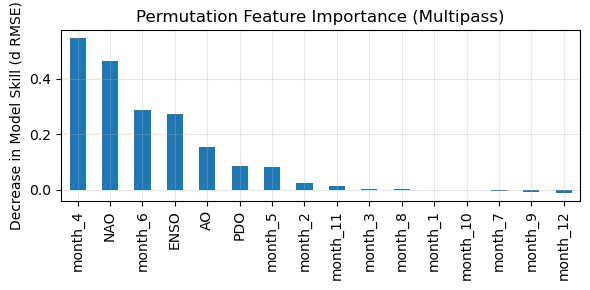

In [40]:
plt.figure(figsize=(6, 3))
perm_importance["mean_importance"].plot(kind="bar")
plt.ylabel("Decrease in Model Skill (d RMSE)")
plt.title("Permutation Feature Importance (Multipass)")
plt.grid(True,alpha=0.3)
plt.tight_layout()
plt.show()


The most important features are all four indicies (NAO, PDO, AO, ENSO). This indicates that climate indices are important for predicting tornado counts. From the multi-pass permutation analysis, the result is similar, but it reveals that certain months are more important than even the climate indicies (April, June, which are both months with greater tornado activity).

6. Create a SHAP Summary Plot showing feature importance and feature effects.


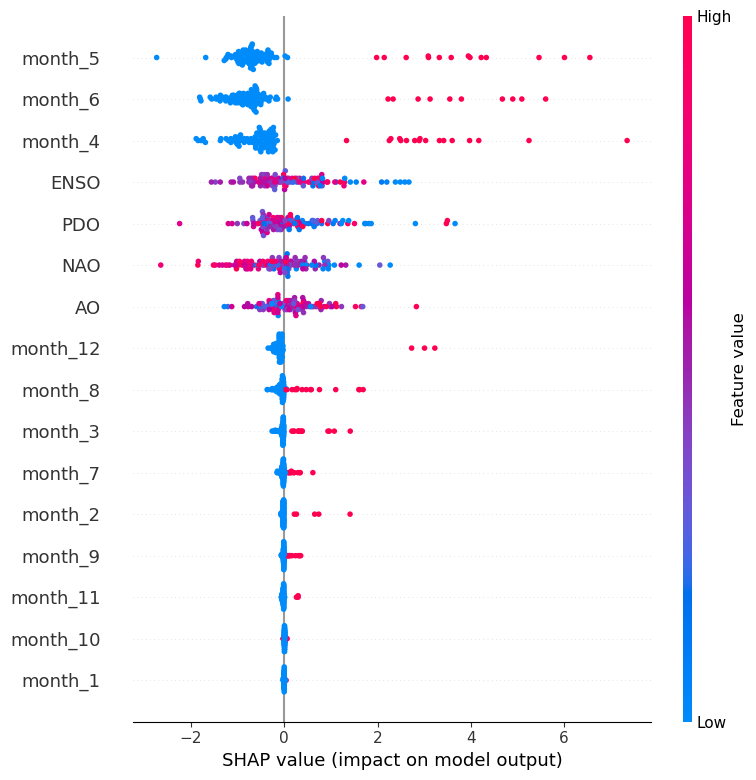

In [41]:
explainer = shap.TreeExplainer(rf_month)

shap_values = explainer.shap_values(X_test)

plt.figure()
shap.summary_plot(
    shap_values,
    X_test,
    feature_names=X_month.columns,
    show=False
)
plt.tight_layout()
plt.show()


7. Create a SHAP Feature Dependence for the ENSO index.


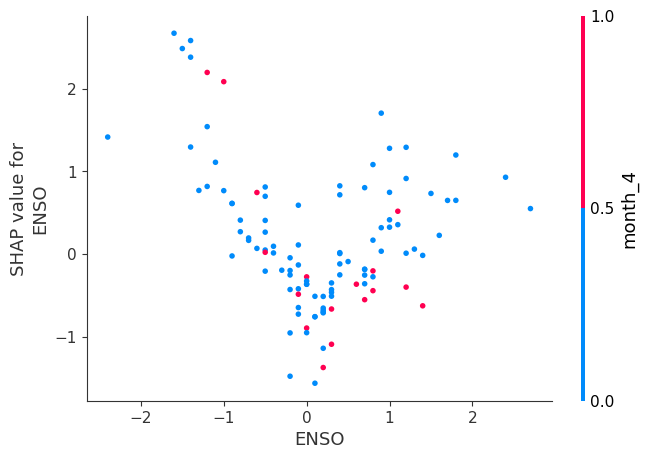

In [42]:
shap.dependence_plot(
    "ENSO",
    shap_values,
    X_test,
    feature_names=X_month.columns,
    show=True
)


8. Any observations on the importance of the various features in your model from the XAI techniques you tried?


- Seasonality is more important to predict tornado counts than climate modes. This makes sense because despite interannual variability, April through June are still the most active months for tornadoes.
- The importance of the features from the random forest model can be misleading because it said the climate modes were the most important, but from the SHAP analysis they had more of a secondary importance.
- This analysis shows how important feature analysis and XAI is to understand why a model does or doesn't work.